<a href="https://colab.research.google.com/github/Priyanka-Police-Reddy-Gari/CreditRisk_ML/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In this project we will build a Credit Risk model to predict probability of default of a loan applicant.

You can download the data from: https://www.kaggle.com/wordsforthewise/lending-club

Steps:
1. Read and Explore the data
2. Clean the data (exclude unnecessary rows and columns)
3. Define the target variable
4. Data processing - the XGB package we use can handle missing values, so no need to impute missing values. Also as discussed in the class. Ensemble models do not need outlier treatment and feature scaling. So the only processing needed would be One-Hot encoding of categorical variables.
5. Test-Train split
6. Feature reduction
7. Train the model / Grid search

# Note: I didn't have the data dictionary for this project; so not sure about the meaning of many columns, ... and I built a story to present the project. The point is that look at this project as a demo which is similar to a real project, and generalize it to other projects. All ML projects more or less go through the same steps and thought process.

In [ ]:
# this step is to read data on Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Due to memory issues we read only the first 1,000,000 observations
data=pd.read_csv("drive/My Drive/accepted.csv", nrows = 1000000)

<ipython-input-36-2c0c89dadf7a>:2: DtypeWarning: Columns (0,19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("drive/My Drive/accepted.csv", nrows = 1000000)


## 1. Data Exploration


In [ ]:
# check data shape
data.shape
# 151 columns

(1000000, 151)

In [ ]:
# take a look at data
data.tail(5)

# as you can see python does not show all columns when there are many of them. One way to check all the columns is to save a few rows as a csv file and check the file.

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
999995,75333445,NaN,35000.0,35000.0,35000.0,36 months,10.75,1141.72,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
999996,74582703,NaN,28000.0,28000.0,28000.0,60 months,20.75,753.57,E,E2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
999997,75295505,NaN,23575.0,23575.0,23575.0,36 months,20.75,885.17,E,E2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
999998,75144864,NaN,20000.0,20000.0,20000.0,60 months,19.53,524.67,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
999999,75275669,NaN,25000.0,25000.0,25000.0,60 months,8.39,511.59,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# check data types
data.dtypes

# again, python only shows some rows. So we save them as a csv file.

id                        object
member_id                float64
loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 151, dtype: object

In [ ]:
types_as_pd = pd.DataFrame(data.dtypes)
types_as_pd.to_csv("drive/My Drive/types_as_pd.csv")

## 2. Data Cleaning - Feature and Observation Exclusion

**2.1. Feature Exclusion:** To do a good feature exclusion we need to have the data dictionary, which is missing here. So we go by guessing meaning of features.

Some features do not contain any logical information, like ID; so they will not be used in the model, and we exclude them from the beginning.

Also there are features that are realted to Loan characteristics, such as loan's term and interest rate. The goal of this model is to estimate probability of default, to decide whether to approve or reject a loan applicant. Loan characteristics are defined once the reject/approve decision is made. In other words, when deciding on an application, loan characteristic data do not exist. So we exclude these features as well, because at the time of decision they do not exist, and can not be used to predict probability of default.

We also remove some features that are allowed to be used in a loan application decision, such as Zip Code, ...

# This is a very important concept, and a lot of times ignored by even experienced modelers. Always think about when the model will be applied, and only use features that are available at the model execution time.

In [ ]:
final_data = data.drop(["id", "member_id", "loan_amnt", "funded_amnt", "funded_amnt_inv", "term",
                        "int_rate", "installment", "grade", "sub_grade", "url", "desc", "purpose"
                        , "title", "zip_code", "addr_state", "policy_code"], axis = 1)

In [ ]:
# check the data frequently
final_data.shape

(1000000, 134)

**2.2. Observation Exclusion:** Observation exclusion is often the most time consuming part of a ML project. The goal here is to exclude observations that do not represent the Target Population; i.e. observations that make the modeling sample Biased.

Defining exclusions often requires a good understanding of the business, and is done in collaboration with model users, through several meetings.

In a Credit Risk project, we often exclude inactive accounts; for example accounts that have been paid off or charged off. Also we exclude accounts that are under any treatment. Treatments are plans to help customers who are in some sort of financial hardship. Examples are temporarily reduction in monthly payments, posptpone payments, ...

In [ ]:
# remove inactive and paid off acounts.
# Loan_Status is a feature that shows status of a loan. We will use this feature to identify inactive accounts.
# We will later use the same feature to define the target variable.
# Let's check categories of this feature.

final_data.groupby(["loan_status"]).size()



loan_status
Charged Off           121189
Current               411982
Default                   20
Fully Paid            450285
In Grace Period         3997
Late (16-30 days)       2040
Late (31-120 days)     10475
dtype: int64

In [ ]:
# We exclude Charge Off, Fully Paid, and Default
final_data = final_data[(final_data.loan_status != "Charged Off") & (final_data.loan_status != "Default") &
                        (final_data.loan_status != "Fully Paid")]

In [ ]:
# check
final_data.groupby(["loan_status"]).size()

loan_status
Current               411982
In Grace Period         3997
Late (16-30 days)       2040
Late (31-120 days)     10475
dtype: int64

In [ ]:
# exclude observations under treatment. There are three groups of features that are related to treatments: hardship, settlement, and payment plan
print (final_data.groupby(["hardship_flag"]).size())
print (final_data.groupby(["debt_settlement_flag"]).size())
print (final_data.groupby(["pymnt_plan"]).size())

final_data = final_data[(final_data.hardship_flag != "Y") & (final_data.debt_settlement_flag != "Y") &
                        (final_data.pymnt_plan != "y")]

hardship_flag
N    428069
Y       425
dtype: int64
debt_settlement_flag
N    428063
Y       431
dtype: int64
pymnt_plan
n    428183
y       311
dtype: int64


In [ ]:
# check
print (final_data.groupby(["hardship_flag"]).size())
print (final_data.groupby(["debt_settlement_flag"]).size())
print (final_data.groupby(["pymnt_plan"]).size())

hardship_flag
N    427638
dtype: int64
debt_settlement_flag
N    427638
dtype: int64
pymnt_plan
n    427638
dtype: int64


In [ ]:
# We also remove features that are related to these plans, as we do not consider those observations for modeling
final_data.drop(["hardship_flag", "hardship_type", "hardship_reason", "hardship_status",
                 "deferral_term", "hardship_amount", "hardship_start_date", "hardship_end_date",
                 "payment_plan_start_date", "hardship_length", "hardship_dpd", "hardship_loan_status",
                 "orig_projected_additional_accrued_interest",
                 "hardship_payoff_balance_amount", "hardship_last_payment_amount", "disbursement_method",
                 "debt_settlement_flag", "debt_settlement_flag_date", "settlement_status",
                 "settlement_date", "settlement_amount", "settlement_percentage", "settlement_term"], axis = 1, inplace = True)

In [ ]:
# Final check of the list of variables and remove any feature left that needs to be removed
types_as_pd = pd.DataFrame(final_data.dtypes)
types_as_pd.to_csv("drive/My Drive/types_as_pd.csv")

In [ ]:
# this column was left
final_data.drop(["pymnt_plan"], axis = 1, inplace = True)

In [ ]:
# Eventually we check a few records to make sure we are only including features that make sense.
final_data.head(50).to_csv("drive/My Drive/top_50.csv")

In [ ]:
# there are some fields related to date. To use these fields we often need to know when the data was gathered, so we can convert the field to
# like time since X rather than date of X. Since we do not know data gathering date, we remove these fields as well.
final_data.drop(["issue_d", "earliest_cr_line", "last_pymnt_d",
                 "next_pymnt_d", "last_credit_pull_d"], axis = 1, inplace = True)

## 3. Define the target variable: there is no variable indicating default/no default. We use "loan_status" variable to define default.

In [ ]:
# check categories
print (final_data.groupby(["loan_status"]).size())

loan_status
Current               411967
In Grace Period         3984
Late (16-30 days)       1992
Late (31-120 days)      9695
dtype: int64


In [ ]:
# We define everyone who is current or in grace priod as good (0), and others as bad (1).
final_data['30+ Delinquent'] = np.where((final_data.loan_status == "Current") |
                                        (final_data.loan_status == "In Grace Period"),0, 1)

In [ ]:
# check
print (final_data.groupby(["30+ Delinquent"]).size())

30+ Delinquent
0    415951
1     11687
dtype: int64


In [ ]:
# we don't need the loan_status attribute anymore
final_data.drop(['loan_status'], axis=1, inplace=True)

## 4. Data Processing: As mentioned, for this XGBoost package we only need to do one-hot encoding. Outlier treatment and feature scaling generally are not needed for tree-based methods. Also this package can automatically handle missing values, just need to make sure all missing values are stored as NaN.

In [ ]:
# list of categorical variables - we need to address them one by one
final_data.dtypes[final_data.dtypes == "object"]

# we will first check how many categories in each attribute

emp_title                    object
emp_length                   object
home_ownership               object
verification_status          object
initial_list_status          object
application_type             object
verification_status_joint    object
sec_app_earliest_cr_line     object
dtype: object

In [ ]:
# emp_title
print (final_data.groupby(["emp_title"]).size())

# this attribute has many classes. We can keep it and define some clusters of jobs ... but here for simplicity we just remove it.
final_data.drop(['emp_title'], axis=1, inplace=True)

emp_title
\tCFO                              1
                                   2
 \tDriver                          1
 \tIT internal support             1
    Food Preparation Worker        1
                                  ..
zone vice president                1
zookeeper                          1
{Owner}Truck Driver                1
​Associate Tech Support Analyst    1
​Financial Analyst                 1
Length: 116106, dtype: int64


In [ ]:
# emp_length
print (final_data.groupby(["emp_length"]).size())

# classes of this attribute have an order, so we have the option to replace them with numbers, rather than do one-hot encoding
final_data['Employment_Length'] = np.nan
final_data['Employment_Length'] = np.where(final_data.emp_length == "< 1 year", 0, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "1 year", 1, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "2 years", 2, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "3 years", 3, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "4 years", 4, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "5 years", 5, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "6 years", 6, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "7 years", 7, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "8 years", 8, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "9 years", 9, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "10+ years", 10, final_data.Employment_Length)

# and we remove the original attribute
final_data.drop(['emp_length'], axis=1, inplace=True)

emp_length
1 year        27513
10+ years    143878
2 years       38484
3 years       34320
4 years       26335
5 years       26116
6 years       18469
7 years       15762
8 years       14698
9 years       13851
< 1 year      37424
dtype: int64


In [ ]:
# home_ownership
print (final_data.groupby(["home_ownership"]).size())

# There are few observations in "NONE" and "ANY" categories. Probably not wise to add a column for them (through one-hot encoding)
# We can put "NONE" and "ANY" in one category and then do one-hot encoding. We set these two categories as missing.
final_data['home_ownership'] = np.where(final_data.home_ownership == "NONE", np.NAN, final_data.home_ownership)
final_data['home_ownership'] = np.where(final_data.home_ownership == "ANY", np.NAN, final_data.home_ownership)

# check
print (final_data.groupby(["home_ownership"]).size())

# one-hot encoding
one_hot = pd.get_dummies(final_data['home_ownership'])
print (one_hot.head(10))
final_data = final_data.join(one_hot)

# and we remove the original attribute
final_data.drop(['home_ownership'], axis=1, inplace=True)

home_ownership
MORTGAGE    209643
OWN          50289
RENT        167564
dtype: int64
home_ownership
MORTGAGE    209643
OWN          50289
RENT        167564
dtype: int64
    MORTGAGE  OWN  RENT
3          1    0     0
10         1    0     0
11         1    0     0
18         0    0     1
34         1    0     0
42         1    0     0
48         0    0     1
51         0    1     0
52         1    0     0
53         0    1     0


In [ ]:
# We nedd to do the same thing for the rest of attributes. Here for simplicity we just remove them.
final_data.drop(['verification_status', "initial_list_status", "application_type",
                 "verification_status_joint", "sec_app_earliest_cr_line"], axis=1, inplace=True)

In [ ]:
# check
final_data.dtypes[final_data.dtypes == "object"]

# all numerical, so we are fine

Series([], dtype: object)




## 5. Test-Train split

In [ ]:
# We put 30% in test. This is a random split which is not ideal.
# Ideally we would like to split based on another variable, for example time.
# Note that both test and train should be unbiased samples of the whole population.
from sklearn.model_selection import train_test_split
train, test = train_test_split(final_data, test_size=0.3)

In [ ]:
# check
print (train.shape)
print (test.shape)

(299355, 101)
(128295, 101)


In [ ]:
# check - it is a good practice to compare test and train samples to make sure they are not fundamentally different.
# If so, we will get high variance even with a non-overfitted model.
# Here we compare bad rate in both samples.
print (sum(train["30+ Delinquent"])/len(train["30+ Delinquent"]))
print (sum(test["30+ Delinquent"])/len(test["30+ Delinquent"]))

0.027305373219087704
0.02747573950660587


## 6. Feature Selection

Before grid search, we should choose only a sub-sample of features that have predictive power. This will significantly increase speed of grid search, while we don't lose a lot of information.

There are several ways to do feature reduction. One good approach is to buid a simple Ensemble model, and choose only features with feature importance higher than say 1%. There is no written prescription here, and it is up to modeler to choose the treshold.

In [ ]:
# Define X and Y varibales to build the ensemble model.
X_train = train.drop(['30+ Delinquent'], axis = 1)
Y_train = train['30+ Delinquent']

X_test = test.drop(['30+ Delinquent'], axis = 1)
Y_test = test['30+ Delinquent']

In [ ]:
# Build a simple XGB model to find important features

import xgboost as xgb
xgb_instance = xgb.XGBClassifier(n_estimators = 20)
model_for_feature_selection = xgb_instance.fit(X_train, Y_train)

In [ ]:
# check feature importances - you can also use SHAP values
feature_importance = {'Feature':X_train.columns,'Importance':model_for_feature_selection.feature_importances_}
feature_importance = pd.DataFrame(feature_importance)
feature_importance.sort_values("Importance", inplace=True,ascending=False)
print (feature_importance.to_string())

                                Feature  Importance
23                 last_fico_range_high    0.199999
16                      total_pymnt_inv    0.056535
19                   total_rec_late_fee    0.043177
78                 pub_rec_bankruptcies    0.029481
13                            out_prncp    0.026500
15                          total_pymnt    0.025704
14                        out_prncp_inv    0.024617
18                        total_rec_int    0.019404
22                      last_pymnt_amnt    0.015814
70                  num_rev_tl_bal_gt_0    0.013631
17                      total_rec_prncp    0.013347
12                            total_acc    0.013093
66                            num_bc_tl    0.012414
49                       bc_open_to_buy    0.012269
7                mths_since_last_record    0.012144
3                        fico_range_low    0.012065
71                             num_sats    0.012010
76                       pct_tl_nvr_dlq    0.011986
6           

In [ ]:
# choose featires with FI higher than 1%
final_features = feature_importance["Feature"][feature_importance.Importance > 0.01]

X_train = X_train[final_features]
X_test = X_test[final_features]

In [ ]:
# check
print (X_train.shape)
print (X_test.shape)

(299355, 21)
(128295, 21)


## 7. Grid Search (parameter tuning) and Bias/Variance analysis

We will play with two most important parameters of XGB: # trees, and learning rate.

Large values for # trees would make the process very slow. We often start with not very large numbers, and only increase number if we see a significant improvement as # trees increase.

In [ ]:
# Here we do grid search only on #trees, and look at the AUC as performance metric.

from sklearn.metrics import roc_auc_score
table = pd.DataFrame(columns = ["Num Trees", "Learning Rate", "AUC Train", "AUC Test"])

row = 0
for num_trees in [20, 50, 100, 200]:
  for LR in [0.001, 0.01, 0.1, 0.5]:
    xgb_instance = xgb.XGBClassifier(n_estimators=num_trees, learning_rate = LR)
    model = xgb_instance.fit(X_train, Y_train)

    table.loc[row,"Num Trees"] = num_trees
    table.loc[row,"Learning Rate"] = LR
    table.loc[row,"AUC Train"] = roc_auc_score(train['30+ Delinquent'], model.predict_proba(X_train)[:,1])
    table.loc[row,"AUC Test"] = roc_auc_score(test['30+ Delinquent'], model.predict_proba(X_test)[:,1])

    row = row + 1

table.to_csv("drive/My Drive/results.csv")

,Num Trees,Learning Rate,AUC Train,AUC Test
0,20,0.001,0.88227,0.881649
1,20,0.01,0.884698,0.883575
2,20,0.1,0.906944,0.902341
3,20,0.5,0.934161,0.914761
4,50,0.001,0.882465,0.881714
5,50,0.01,0.894117,0.893124
6,50,0.1,0.921776,0.910859
7,50,0.5,0.958861,0.922376
8,100,0.001,0.882914,0.882148
9,100,0.01,0.902243,0.899353


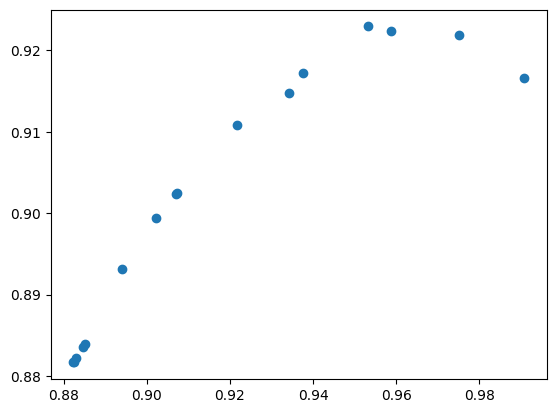

In [ ]:
import matplotlib.pyplot as plt
#table.plot(x="AUC Train", y="AUC Test", "ro")
plt.scatter(table["AUC Train"], table["AUC Test"])

## Final Model Selection

At 0.5 LR we see some increase in variance. LR = 0.1 seems more reasonable. Also not much improvement seen from LR = 100 to 200. So we go with #tree = 100 and LR = 0.1.

Note: Choice of best model is often a subjective decision, but we always prefer to go with simpler model if possible.

In [ ]:
# Re-build and save the final model
xgb_instance = xgb.XGBClassifier(n_estimators=100, learning_rate = 0.1)
final_model = xgb_instance.fit(X_train, Y_train)

**Check Rank Ordering**: Rank ordering means observations with higher Probability of Default should have higher default rate (actual default rate). If we see a rank ordering break, the model needs a fix.

In [ ]:
train["Prediction"] = final_model.predict_proba(X_train)[:, 1]

<Axes: xlabel='Score Bins'>

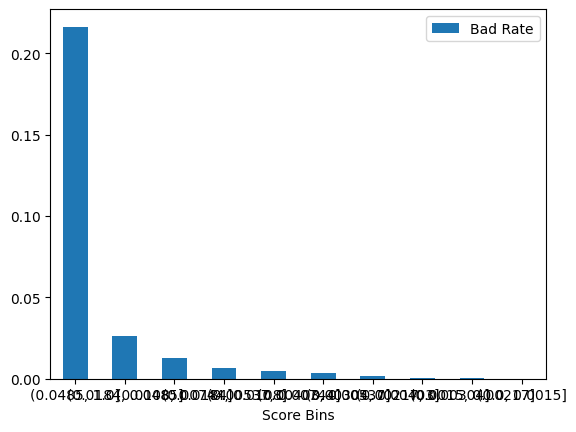

In [ ]:
# Rank Ordering
quantiles = list(set(train.Prediction.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))
quantiles.sort()
quantiles.insert(0,0)
quantiles.insert(len(quantiles),1)


train["Score Bins"] = pd.cut(train["Prediction"], quantiles)
stat = train.groupby("Score Bins")["30+ Delinquent"].agg(["sum", "count"])
stat["Bad Rate"] = stat["sum"] / stat["count"]
stat.sort_values(["Bad Rate"],ascending=False, inplace=True)

#plt.bar(stat["Bad Rate"], color ='maroon',
 #       width = 0.4)

stat.plot.bar(y='Bad Rate', rot=0)

<Axes: xlabel='Score Bins'>

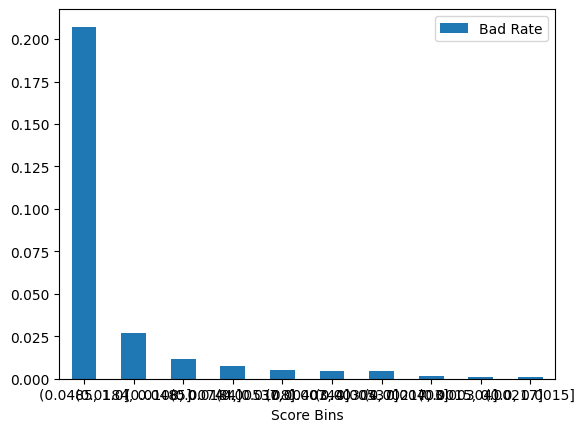

In [ ]:
test["Prediction"] = final_model.predict_proba(X_test)[:, 1]

test["Score Bins"] = pd.cut(test["Prediction"], quantiles)
stat = test.groupby("Score Bins")["30+ Delinquent"].agg(["sum", "count"])
stat["Bad Rate"] = stat["sum"] / stat["count"]
stat.sort_values(["Bad Rate"],ascending=False, inplace=True)

stat.plot.bar(y='Bad Rate', rot=0)